# SMS spam predictor

This project is aimed to predict spam messages. Multinomial Naive Bayes classifier over the "bag of words" model is used. Feature vector comprises text-term counts matrix and engineered features. 

Stratified 5-fold gives 0.993366 F<sub>1</sub> score.

In [1]:
import string
from pprint import pprint
import pandas as pd
import numpy as np
from scipy import sparse

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import tabletext
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../data/sms.csv', encoding = "ISO-8859-1", index_col=0)
data.head()

,text,label
1,Urgent! call 09061749602 from Landline. Your c...,spam
2,+449071512431 URGENT! This is the 2nd attempt ...,spam
3,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,spam
4,Urgent! call 09066612661 from landline. Your c...,spam
5,WINNER!! As a valued network customer you have...,spam


### Let's take a look at class balance:

In [3]:
def print_class_balance(data):
    balance = data["label"].value_counts()
    print("Spam: {:.2f}%, not spam: {:.2f}%".format(balance["spam"]*100/len(data), balance["not spam"]*100/len(data)))

print_class_balance(data)

Spam: 24.32%, not spam: 75.68%


### Checking for NaN and Nulls

In [4]:
data.isna().any().any() or data.isnull().any().any()

False

### Checking for duplicates

In [5]:
duplicates = data[data.duplicated(['text'], keep=False)]
len(duplicates)

73

### Do all duplicates for a particular text have the same label?

In [6]:
sum([len(group["label"].value_counts()) for _, group in duplicates.groupby("text")]) == len( duplicates.groupby("text"))

True

### Now we can safely drop duplicates

In [7]:
data = data.drop_duplicates().reset_index(drop=True)
print_class_balance(data)

Spam: 23.85%, not spam: 76.15%


### Convert labels to [0, 1]

In [8]:
data["label"] = data["label"].map(lambda x: 1 if x == "spam" else 0)


### Tokenize data

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
tokens = []
sentences = []
stop = stopwords.words('english') + list(string.punctuation) + list(["``", "''", '""'])

for row in data.iterrows():
    text = row[1][0]
    tok = [wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(text) if w not in stop]
    tokens.append(tok)
    sentences.append(" ".join(tok))

### Get counts and TF-IDF

In [10]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(sentences)
print(X_counts.shape)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_tfidf.shape

(1279, 3385)


(1279, 3385)

### Baseline for counts and TF-IDF

In [11]:
def get_score(dataset):
    baseline_parameters = {"alpha":np.linspace(0.001, 100, 1000)}
    clf = MultinomialNB()
    gs = GridSearchCV(clf, baseline_parameters, scoring=make_scorer(f1_score, pos_label=0), cv=5, n_jobs=-1)
    baseline_clf = gs.fit(dataset, data["label"])
    return baseline_clf.best_score_, baseline_clf.best_params_

In [12]:
get_score(X_counts), get_score(X_tfidf)

((0.9923055148363433, {'alpha': 16.717549549549553}),
 (0.9912650763056334, {'alpha': 0.5014954954954955}))

### Feature engineering

In [13]:
def get_features(text):
    stop = stopwords.words('english') + list(string.punctuation) + list(["``", "''", '""'])
    wordnet_lemmatizer = WordNetLemmatizer()
    snowball_stemmer = SnowballStemmer("english")
    tokens = [snowball_stemmer.stem(w) for w in word_tokenize(text) if w not in stop]
    wordnet_tokens = [wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(text) if w not in stop]
    f = []
    f.append(len(tokens)) # number of words
    f.append(sum([1 for word in wordnet_tokens if word.isupper()])) # number of upper words
    f.append(sum([1 for word in wordnet_tokens if word.islower()])) # number of lower words
    f.append(text.count("0")) # number of 0
    f.append(text.count("1")) # number of 0
    f.append(text.count("£")) # number of £
    f.append(len([1 for word in tokens if word.isnumeric()])) # number of 0-9 WORDS
    f.append(min([len(word) for word in tokens])) # min word length
    f.append(max([len(word) for word in tokens])) # max word length
    f.append(sum([len(word) for word in tokens])) # number of symbols
    f.append(np.mean([len(word) for word in tokens])) # mean number of symbols
    f.append(sum([1  for word in tokens for letter in word if letter.isalpha()])) 
    
    f.append(sum([1  for word in tokens for letter in word if letter.isnumeric() and letter != '0' and letter != '1' ])) # number of digits
    f.append(sum([1  for word in wordnet_tokens for letter in word if letter.isupper()])) # number of upper letters
    f.append(sum([1  for word in wordnet_tokens for letter in word if letter.islower()])) # number of lower letters
    usual = ["sex", "won", "winner", "xchat", "free", "xxx", "18+", "cash", "prize", "urgent", "call", "you", "congratulations", "congrats"]
    f.append(sum([1 for word in tokens if word.lower() in usual])) # keywords
    return f

additional_features = []
for row in data.iterrows():
    text = row[1][0]
    additional_features.append(get_features(text))

engineered_columns = np.array([
        '# of words',
        "# of upper words",
        "# of lower words",
         "# of 0",
         "# of 1",
         "# of £", 
         "# of 0-9 WORDS",  
         "min word length", 
         "max word length", 
         '# of symbols', 
         'mean number of symbols', 
         '# of a-z', 
         '# of 0-9', 
         '# of upper', 
         "# of lower", 
         '# of spam words'])

engineered = pd.DataFrame(additional_features, columns=engineered_columns)

### Baseline for engineered features

In [14]:
print(get_score(engineered))
print(get_score(sparse.hstack((X_counts, engineered))))
print(get_score(sparse.hstack((X_tfidf, engineered))))

(0.9160462369795318, {'alpha': 80.38057657657659})
(0.9366815423124005, {'alpha': 0.001})
(0.9288024829356325, {'alpha': 0.001})


### Get best engineered features using recursive feature elimination

In [15]:
def get_rfe(dataset):
    rfe_best_score = -np.inf
    rfe_best = set()
    for n in range(1, dataset.shape[1]):
        print("\r %d, max f1: %f" % (n, rfe_best_score), end="")
        rfe = RFE(MultinomialNB(), n_features_to_select=n)
        rfe = rfe.fit(dataset, data["label"])

        score = get_score(dataset[dataset.columns[rfe.support_]])[0]
        if score > rfe_best_score:
            rfe_best = set(dataset.columns[rfe.support_].tolist())
            rfe_best_score = score
    print("\nMax f1 score: ", rfe_best_score)
    return rfe_best_score, rfe_best
    
get_rfe(engineered)

 15, max f1: 0.964813
Max f1 score:  0.9648125412554168


(0.9648125412554168,
 {'# of 0',
  '# of 0-9 WORDS',
  '# of 1',
  '# of spam words',
  '# of upper words',
  '# of £',
  'min word length'})

### Get best features using trees and feature importances

In [16]:
def get_importances(dataset):
    extra_tree = ExtraTreesClassifier()
    extra_tree.fit(dataset, data["label"])
    l = list(zip(dataset.columns, extra_tree.feature_importances_))
    extra_tree_list = sorted(l, key=lambda x: x[1], reverse=True)
    extra_tree_best_indexes = [np.where(dataset.columns == row[0])[0][0] for row in extra_tree_list]
    
    max_f1 = -np.inf
    max_n = -np.inf
    for n in range(1, dataset.shape[1]):
        s = get_score(dataset[dataset.columns[extra_tree_best_indexes[:n]]])
        if s[0] > max_f1:
            max_f1 = s[0]
            max_n = n

        print("\r", s, end="")
    return max_f1, dataset.columns[extra_tree_best_indexes[:max_n]]
            
get_importances(engineered)

 (0.9136403264936064, {'alpha': 52.95342342342342}))

(0.9656382326053579,
 Index(['# of 0', '# of 1', '# of 0-9', '# of symbols', '# of £'], dtype='object'))

### Get best features using trees and feature importances

In [17]:
def get_kbest(dataset):
    max_f1 = -np.inf
    max_n = -np.inf
    for i in range(1, dataset.shape[1]):
        k_best = SelectKBest(score_func=chi2, k=i).fit(dataset, data["label"]) 
        k_best_list = sorted(list(zip(dataset.columns, k_best.scores_)), key=lambda x: x[1], reverse=True)

        k_best_indexes = [np.where(dataset.columns == name)[0][0] for name in [i for i,j in k_best_list]]
        s = get_score(dataset[dataset.columns[k_best_indexes[:i]]])
        print("\r%d " %i, s, end="")
        if s[0] > max_f1:
            max_f1 = s[0]
            max_n  = i
    return max_f1, dataset.columns[k_best_indexes[:max_n]]
        
get_kbest(engineered)

15  (0.9136403264936064, {'alpha': 52.95342342342342}))

(0.9631984060779601, Index(['# of symbols', '# of 0-9'], dtype='object'))

### Scores are too different, let's look at features manually

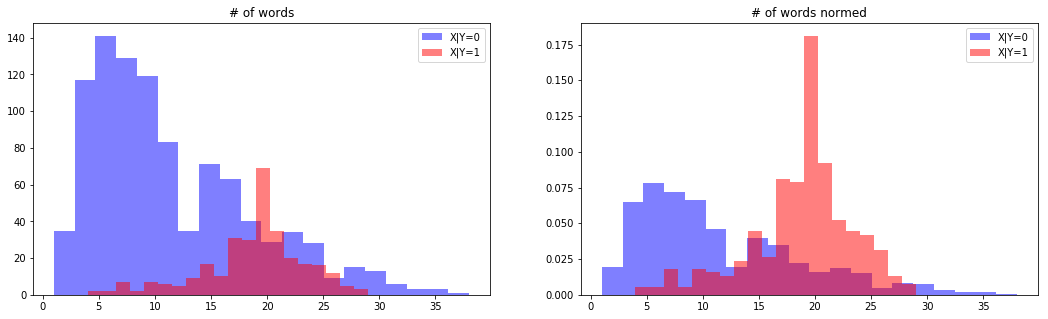

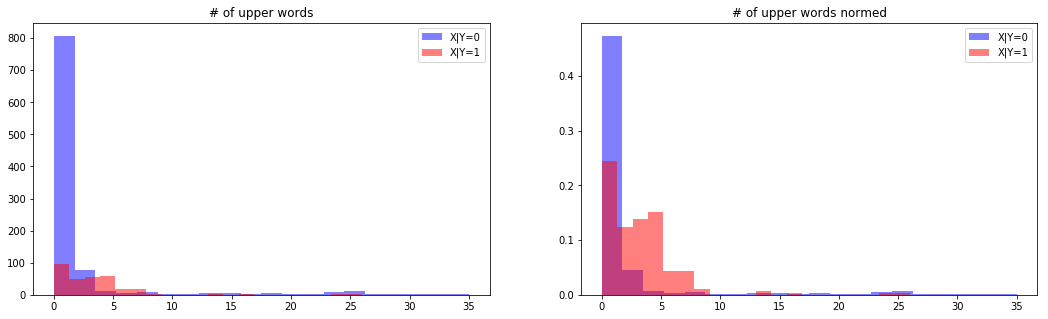

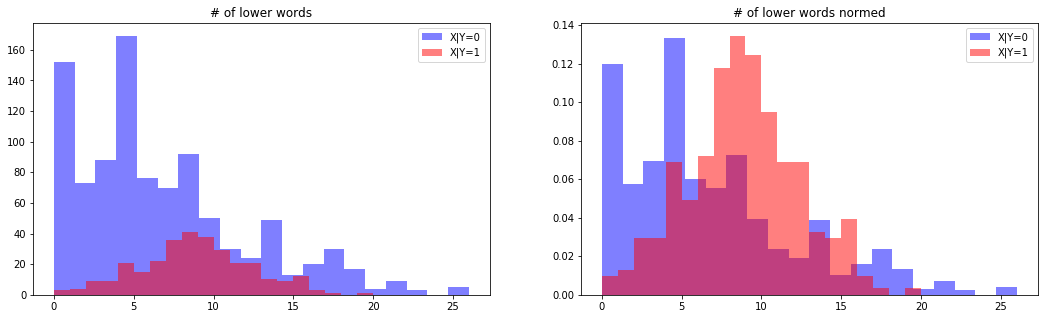

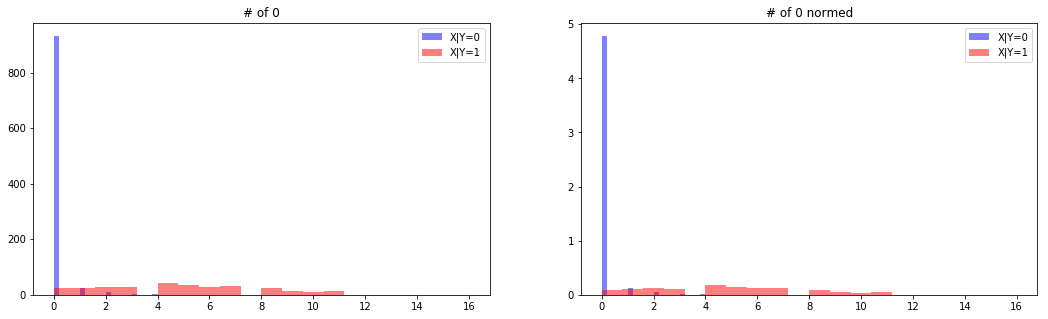

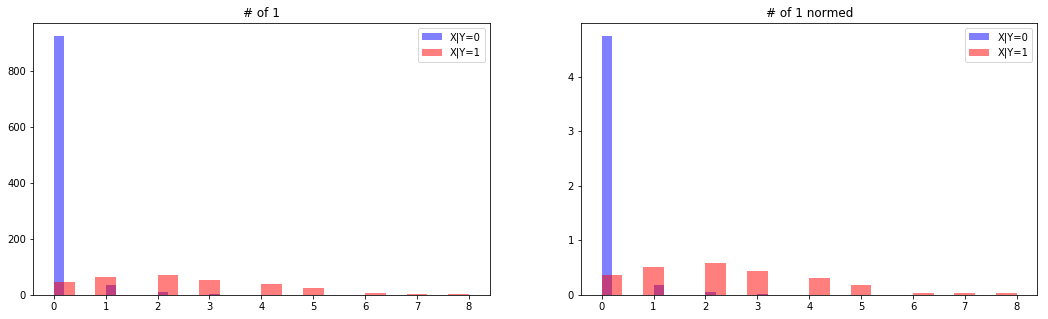

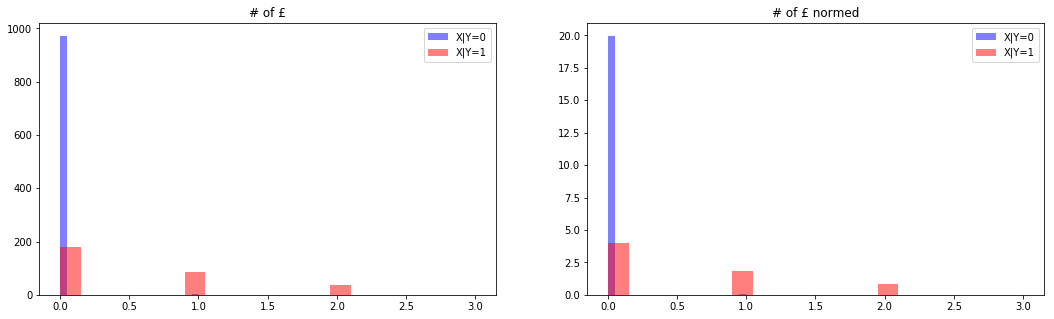

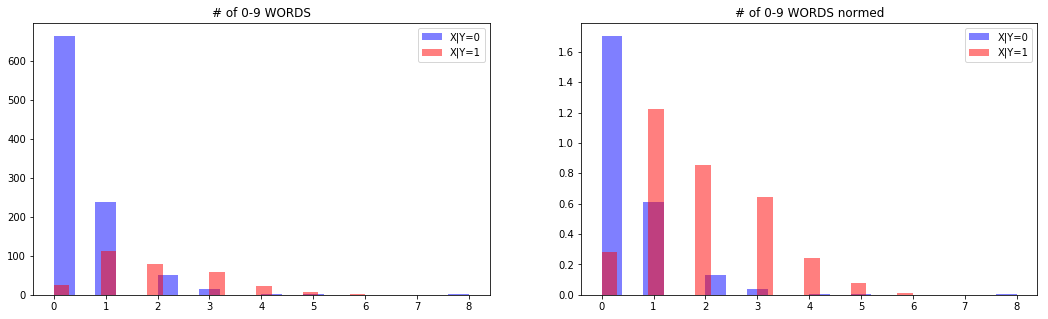

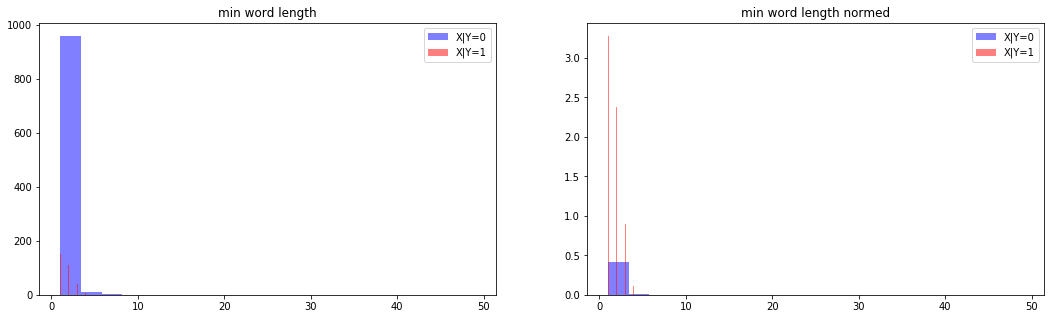

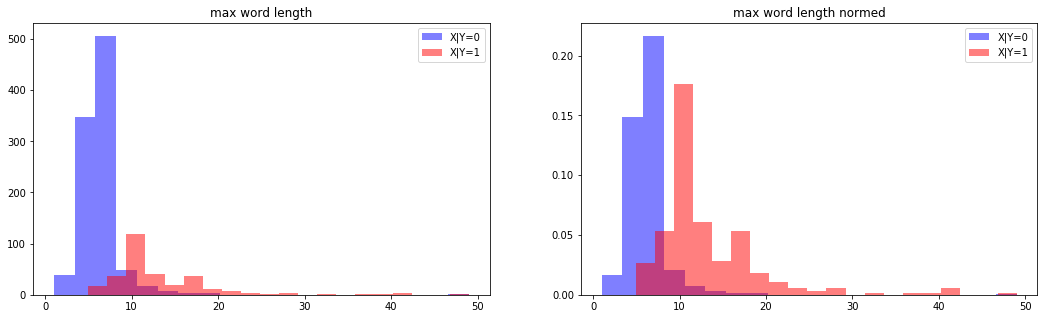

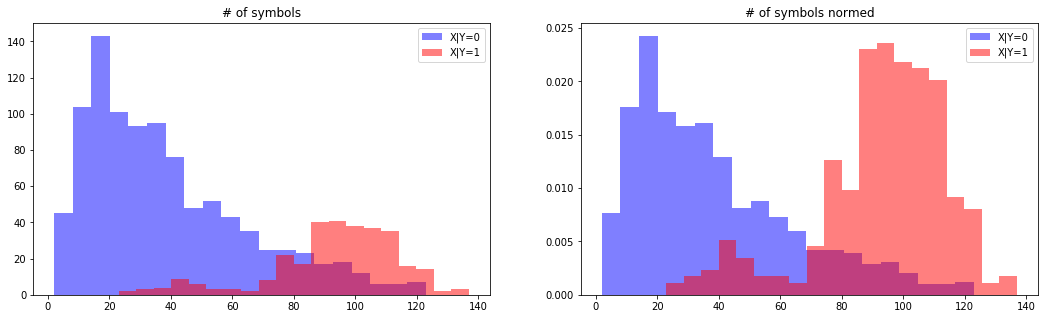

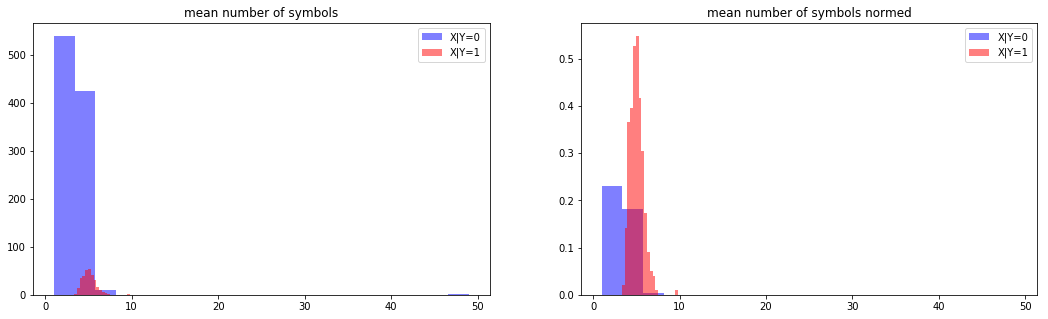

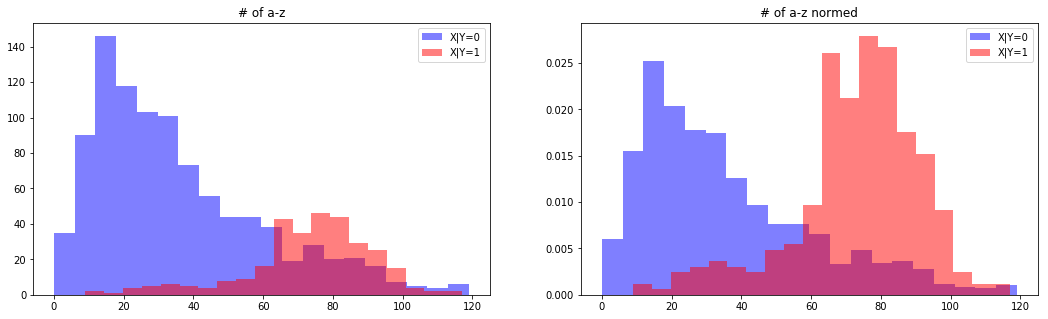

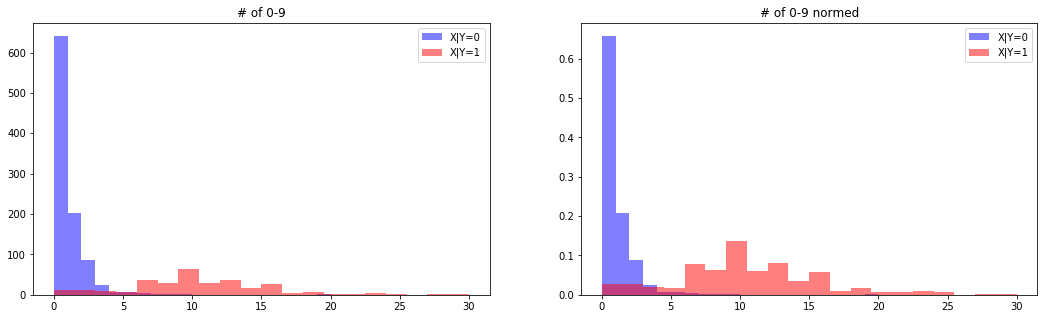

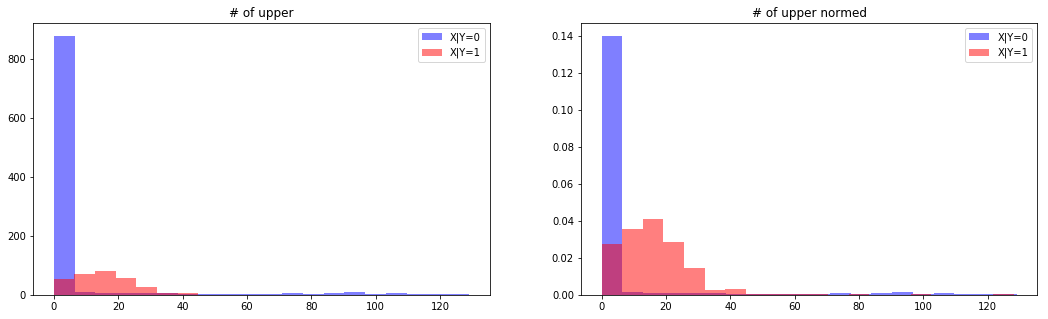

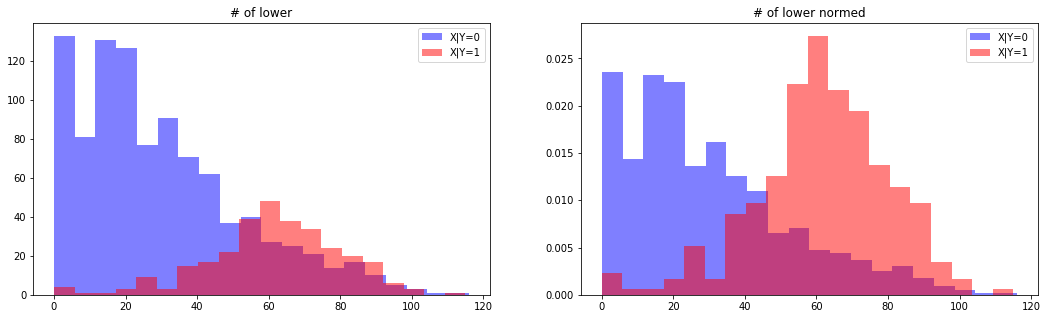

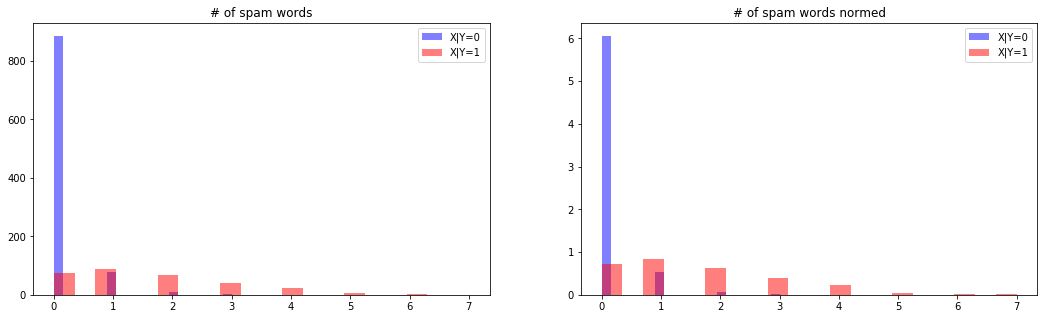

In [18]:
for i in range(len(additional_features[0])):
    fig, ax = subplots(1, 2, figsize=[18, 5])
    j = 0
    for norm in [False, True]:
        ax[j].hist(engineered.values[data["label"]==0, [i]], bins=20, color='b', alpha=0.5, label='X|Y=0', normed=norm);
        ax[j].hist(engineered.values[data["label"]==1, [i]], bins=20, color='r', alpha=0.5, label='X|Y=1', normed=norm);
        ax[j].set_title(engineered.columns[i] + (" normed" if norm else ""))
        ax[j].legend()
        j += 1

As we can see, features "# of upper words", "min word length", "# of lower words" and "mean number of symbols" are not separable.


On the contrary, features "# words", "# of symbols", "# of a-z", "# of 0-9", "# of UPPER" and "# of lower" are separable.


Features "# of 0", "# of 1", "# of £", "# of spam words" look like indicator features: they have 0 in most samples of class 0.


If normed, features "# of words", "# of upper words", "max word length", "# of symbols",  are separable

Normed "# of lower words", "# of 0-9 WORDS", "mean number of symbols" could be separable if normed

## Scores after feature normalization

In [19]:
engineered_minmax =  MinMaxScaler().fit_transform(engineered)
engineered_minmax = pd.DataFrame(engineered_minmax, columns=engineered.columns)    
get_score(engineered_minmax.values)

(0.959756018955133, {'alpha': 1.001990990990991})

In [20]:
get_score(sparse.hstack((X_counts, engineered_minmax)))

(0.9902624584648405, {'alpha': 16.81764864864865})

In [21]:
get_score(sparse.hstack((X_tfidf, engineered_minmax)))

(0.9847140663987428, {'alpha': 0.5014954954954955})

### Let's explore the Pearson correlation of features

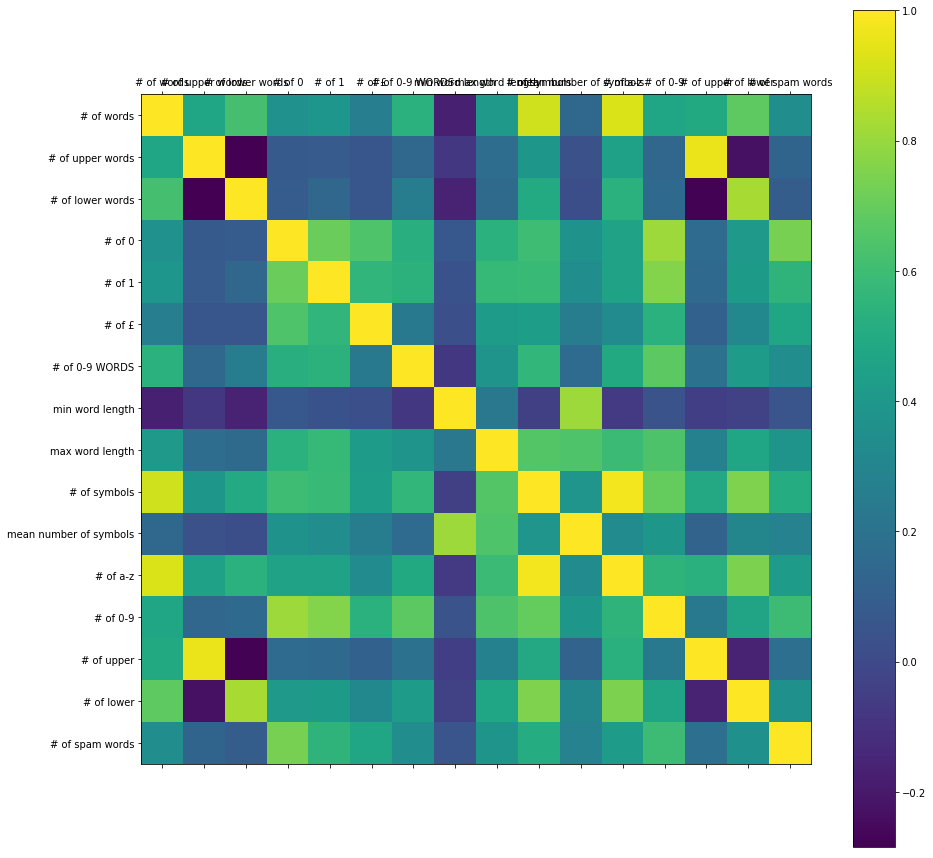

In [22]:
plt.figure(figsize=(15, 15))
plt.matshow(engineered_minmax.corr(), fignum=1)
plt.xticks(range(len(engineered_minmax.columns)), engineered_minmax.columns)
plt.yticks(range(len(engineered_minmax.columns)), engineered_minmax.columns)
plt.colorbar()
plt.show()

Yellow squares that are off the main diagonal are examples of linearly dependent features:

\# of words - \# of a-z

\# of words - \# of symbols

\# of symbols - \# of a-z

\# of upper words - \# of upper

We have to remove minimum number of features to eliminate correlation.

According to the correlation matrix and previous histogram let's remove features "min word length", "# of £", "# of symbols", "# of upper words", "# of lower words"

In [23]:
feature_mask = [
        True, #'# of words',
        True, #"# of upper words",
        True, #"# of lower words",
        True, #"# of 0",
        True, #"# of 1",
        False, # "# of £",
        True, # "# of 0-9 WORDS",  
        False, #"min word length", 
        True, # "max word length", 
        False, # '# of symbols', 
        True, # 'mean number of symbols',
        True, # '# of a-z', 
        True, # '# of 0-9', 
        False, # '# of upper', 
        False, # "# of lower", 
        True, # '# of spam words'
]

engineered_minmax =  MinMaxScaler().fit_transform(engineered[engineered.columns[feature_mask]])
engineered_minmax = pd.DataFrame(engineered_minmax, columns=engineered.columns[feature_mask])  
get_score(engineered_minmax.values)

(0.9654449967765479, {'alpha': 0.2011981981981982})

## Correlation matrix after removing features

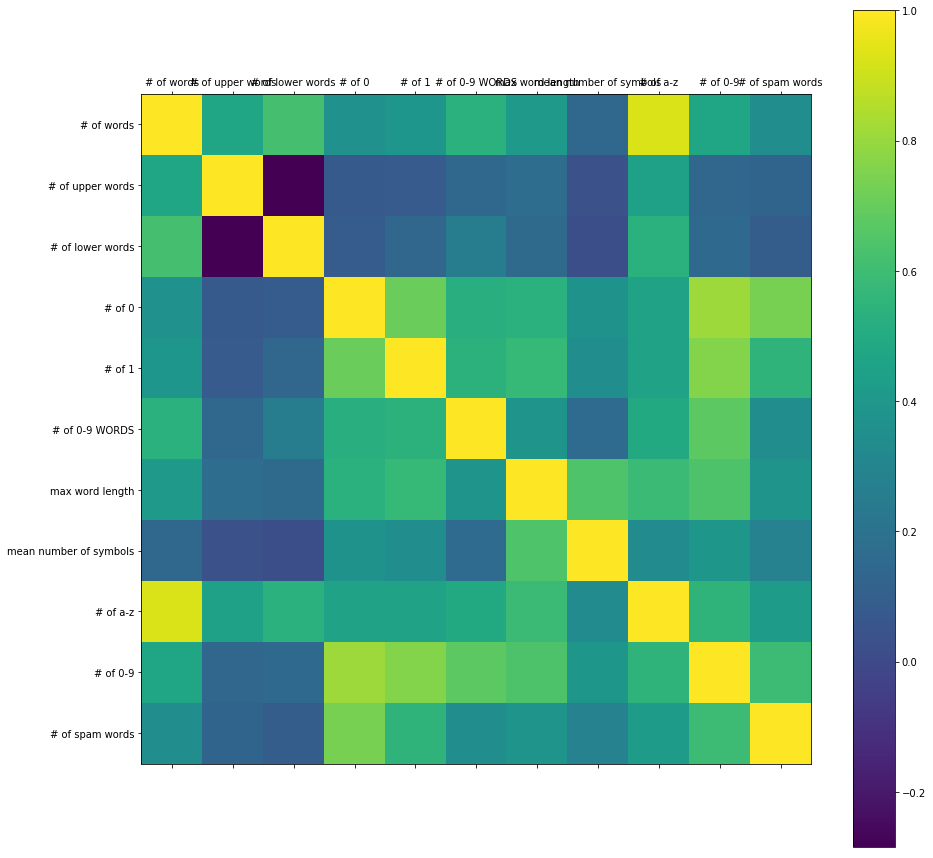

In [24]:
plt.figure(figsize=(15, 15))
plt.matshow(engineered_minmax.corr(), fignum=1)
plt.xticks(range(len(engineered_minmax.columns)), engineered_minmax.columns)
plt.yticks(range(len(engineered_minmax.columns)), engineered_minmax.columns)
plt.colorbar()
plt.show()

# Final experiment

## Try to automatically extract the best from the normalized features

In [25]:
engineered_minmax_full = MinMaxScaler().fit_transform(engineered)
rfe = get_rfe(pd.DataFrame(engineered_minmax_full, columns=engineered.columns))
engineered_rfe = pd.DataFrame(engineered_minmax_full, columns=engineered.columns)[list(rfe[1])]

rfe2 = get_rfe(engineered)
engineered_rfe_full = engineered[list(rfe2[1])]

imp = get_importances(pd.DataFrame(engineered_minmax_full, columns=engineered.columns))
engineered_norm_imp = pd.DataFrame(engineered_minmax_full, columns=engineered.columns)[list(imp[1])]

imp2 = get_importances(engineered)
engineered_imp = engineered[list(imp2[1])]

 15, max f1: 0.961099
Max f1 score:  0.9610993572682939
 15, max f1: 0.964813
Max f1 score:  0.9648125412554168
 (0.9178738956374628, {'alpha': 39.039648648648644})

## An experiment!

In [26]:
classifiers = [MultinomialNB(), LogisticRegression(), SVC(), RandomForestClassifier(), SGDClassifier(n_jobs=-1)]
parameters = [
    {"alpha":np.linspace(0.001, 100, 1000)}, # MultinomialNB
    {"C":np.linspace(0.00001, 10000, 100), "penalty": ["l1", "l2"]}, # Logistic regression
    {"C":np.linspace(0.00001, 1000, 10), "degree":[3, 4, 5, 6, 7, 8, 10, 15]}, #SVC
    {"n_estimators":[5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 100, 125, 150, 175, 200]}, # Random forest
    {"alpha":[0.001, 0.01,0.1, 1, 10, 100, 1000, 10000], "loss":["hinge", "log", "modified_huber", "squared_hinge", "perceptron"], "max_iter":[5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 1000]}, 
]
datasets = {"E":engineered, 
            "E norm":engineered_minmax, 
            "Counts":X_counts,
            "TF-IDF":X_tfidf,
            "E+C":sparse.hstack((X_counts, engineered)), 
            "E+C norm ":sparse.hstack((X_counts, engineered_minmax.values)), 
            "E+TF":sparse.hstack((X_tfidf, engineered)),
            "E+TF norm":sparse.hstack((X_tfidf, engineered_minmax.values)),
            "C+TF":sparse.hstack((X_counts, X_tfidf)),
            "E+C norm rfe":sparse.hstack((X_counts, engineered_rfe)),
            "E+TF norm rfe":sparse.hstack((X_tfidf, engineered_rfe)),
            "E+C rfe":sparse.hstack((X_counts, engineered_rfe_full)),
            "E+TF rfe":sparse.hstack((X_tfidf, engineered_rfe_full)),
            
            "E+C norm imp":sparse.hstack((X_counts, engineered_norm_imp)),
            "E+TF norm imp":sparse.hstack((X_tfidf, engineered_norm_imp)),
            "E+C imp":sparse.hstack((X_counts, engineered_imp)),
            "E+TF imp":sparse.hstack((X_tfidf, engineered_imp)),
            
            "E norm rfe": engineered_rfe,
            "E rfe": engineered_rfe_full,
            "E norm imp": engineered_norm_imp,
            "E imp":engineered_imp,
           }

results = {}
max_f1 = -np.inf
for c, p in zip(classifiers, parameters):
    gs = GridSearchCV(c, p, scoring=make_scorer(f1_score, pos_label=0), cv=5, n_jobs=-1)
    for d in datasets:
        print(str(c)[:str(c).find('(')], "+", d, end="...")
        clf = gs.fit(datasets[d], data["label"])
        max_f1 = max(max_f1, clf.best_score_)
        print(clf.best_score_)
        if d in results:
            results[d].append((clf.best_score_, clf.best_params_))
        else:
            results[d] = [(clf.best_score_, clf.best_params_)]



MultinomialNB + E...0.9160462369795318
MultinomialNB + E+C norm imp...0.9912919028856141
MultinomialNB + E+TF rfe...0.9681283804567756
MultinomialNB + E norm rfe...0.9610993572682939
MultinomialNB + E+C imp...0.9858986759067484
MultinomialNB + E+TF imp...0.9717746948611049
MultinomialNB + E+TF norm...0.9907268612845136
MultinomialNB + E+TF norm rfe...0.9857444837372319
MultinomialNB + E+C...0.9366815423124005
MultinomialNB + E imp...0.940921930742703
MultinomialNB + E norm...0.9654449967765479
MultinomialNB + E+C rfe...0.9869194640510184
MultinomialNB + E+C norm rfe...0.9912705198000774
MultinomialNB + Counts...0.9923055148363433
MultinomialNB + TF-IDF...0.9912650763056334
MultinomialNB + E+C norm ...0.9933659525258196
MultinomialNB + E norm imp...0.9643972711254142
MultinomialNB + E+TF...0.9288024829356325
MultinomialNB + E+TF norm imp...0.987255434337869
MultinomialNB + E rfe...0.9648125412554168
MultinomialNB + C+TF...0.9907875194681897
LogisticRegression + E...0.9529034339433889
Lo

### Show results as a table

In [29]:
table_columns = datasets.keys()
classifier_names = [str(c)[:min(10, str(c).find('('))] for c in classifiers]
table_data = np.array(["Classifier"] + classifier_names).reshape(len(classifier_names)+1, -1)
for dataset in table_columns:
    column = np.array([dataset] + results[dataset])
    table_data = np.hstack((table_data, column.reshape(len(column), -1)))

    
str_data = []
for i in table_data:
    t = []
    for j in i:
        if type(j) == tuple:
            t.append("%.4f" % (j[0]*100))
        else:
            t.append(str(j))
    str_data.append(t)
print(tabletext.to_text(np.array(str_data).T, header=True))
print("Maximum F1: %.4f" % (max_f1*100))

╒═══════════════╤════════════╤════════════╤═════════╤════════════╤════════════╕
│ Classifier    │ Multinomia │ LogisticRe │ SVC     │ RandomFore │ SGDClassif │
╞═══════════════╪════════════╪════════════╪═════════╪════════════╪════════════╡
│ E             │ 91.6046    │ 95.2903    │ 86.4625 │ 97.6836    │ 96.7705    │
├───────────────┼────────────┼────────────┼─────────┼────────────┼────────────┤
│ E+C norm imp  │ 99.1292    │ 98.8826    │ 98.7225 │ 98.9785    │ 99.1772    │
├───────────────┼────────────┼────────────┼─────────┼────────────┼────────────┤
│ E+TF rfe      │ 96.8128    │ 98.2812    │ 96.9267 │ 98.6834    │ 98.0683    │
├───────────────┼────────────┼────────────┼─────────┼────────────┼────────────┤
│ E norm rfe    │ 96.1099    │ 94.4554    │ 95.4686 │ 97.8262    │ 95.7333    │
├───────────────┼────────────┼────────────┼─────────┼────────────┼────────────┤
│ E+C imp       │ 98.5899    │ 99.2354    │ 98.7726 │ 98.8322    │ 98.9225    │
├───────────────┼────────────┼──────────

This is not a production-ready solution for spam detection, so let's divide the code into two files:
* train.py - trains the selected best model on the whole data and saves the trained classifier
* predict.py - accepts sms message as a console argument and makes a prediction


See these files for more information.